# Introdução

> Este trabalho foi baseado no código de Chris McCormick e Nick Ryan, disponível em https://colab.research.google.com/drive/1pTuQhug6Dhl9XalKB0zUGf4FIdYFlpcX

Neste trabalho, irei descreverei o banco de dados utilizado no ajuste de um modelo BERT, assim como as etapas de pré-processamento aplicadas aos dados. Em seguida, apresentarei o detalhamento das etapas de treinamento, validação e teste do modelo ajustado. Para o desenvolvimento desta análise, foi utilizada a linguagem de programação `Python` (versão 3.11.3) em conjunto com o editor de código-fonte Visual Studio Code. Ainda, foram utilizados pacotes em `Python` como `numpy` (Harris et al., 2020) (versão 1.24.4), `pandas` (Wes McKinney, 2010) (versão 2.0.3), `transformers` (Wolf et al., 2019) (versão 4.30.2) e `torch` (Paszke et al., 2019) (versão 2.0.1).

# Setup

In [ ]:
# Importando pacotes e funções
import os
import time
import datetime
import random
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statistics import mean
from collections import Counter
from langdetect import detect, DetectorFactory
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler, Subset
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup

In [2]:
# Declarando constantes
DF_ORIGINAL = r"dados/WELFake_Dataset.csv"
DF_FINAL = r"dados/data.csv"
MODEL_FOLDER = r"dados/model_v1/"

device = torch.device("cpu")
os.environ['CURL_CA_BUNDLE'] = ''  # Caso surja o erro "[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed" rode estes comandos para reduzir a versão do pacote requets: "pip uninstall requests" e "pip install requests==2.27.1"

In [3]:
# Declarando a semente aleatória para que este código seja reprodutível
my_seed = 288933

random.seed(my_seed)
np.random.seed(my_seed)
torch.manual_seed(my_seed)
torch.cuda.manual_seed_all(my_seed)

# Pré-Processamento

O banco de dados original (Verma et al., 2021) foi obtido pelo portal Kaggle e contém informações acerca de 72.134 artigos de notícias na língua inglesa, dos quais 35.028 são notícias verdadeiras e 37.106 são falsas. Para compor o banco, Verma et al. (2021) extraíram artigos dos portais Kaggle, McIntire, Reuters e BuzzFeed Political. O conjunto de dados possui 3 colunas: "title", que apresenta o título da notícia no formato de texto; "text", que apresenta o conteúdo da notícia no formato de texto; e "label", que é 0 para notícias verdadeiras e 1 para falsas. O objetivo deste trabalho é utilizar as colunas "título" e "label" do banco de dados apresentado para ajustar um modelo BERT para classificação binária supervisionada de texto, capaz de detectar quando o título de uma notícia em inglês provém de um artigo falso ou não.

In [4]:
# Importando o banco
df = pd.read_csv(DF_ORIGINAL, index_col=0)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 72134 entries, 0 to 72133
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   71576 non-null  object
 1   text    72095 non-null  object
 2   label   72134 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.2+ MB


,title,text,label
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,NaN,Did they post their votes for Hillary already?,1
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [5]:
df.groupby('label').size()

label
0    35028
1    37106
dtype: int64

In [6]:
# Selecionando somente as colunas de título e de classificação
df = df[['title', 'label']]

n_row_before = len(df)
df = df[~df['title'].isnull()]
df = df[~df['label'].isnull()]

n_row_after = len(df)
print(f'Número de observações removidas por valores nulos nas colunas de título ou de classificação: {n_row_before- n_row_after}')

Número de observações removidas por valores nulos nas colunas de título ou de classificação: 558


In [7]:
# Removendo linhas duplicadas
n_row_before = len(df)
df.drop_duplicates(inplace=True)  # Valores de todas as colunas iguais
df.drop_duplicates(subset='title', keep=False, inplace=True, ignore_index=True)  # Valores removidos aqui são títulos que possuem ambos os labels

n_row_after = len(df)
print(f'Número de observações removidas por valores duplicados: {n_row_before- n_row_after}')

Número de observações removidas por valores duplicados: 9233


Alguns títulos estão em outras línguas além de inglês. Para removê-los, utilizaremos o pacote `langdetect` (versão 1.0.9).

In [8]:
# Classificando os títulos em línguas
DetectorFactory.seed = 0

language = []
for title in df['title']:
    try:
        language.append(detect(title))
    except:
        language.append('error')
        pass

print(Counter(language))

Counter({'en': 60048, 'de': 814, 'fr': 212, 'es': 204, 'ru': 153, 'ca': 152, 'it': 116, 'nl': 96, 'af': 73, 'da': 72, 'no': 68, 'id': 64, 'ro': 50, 'pt': 41, 'et': 27, 'sv': 24, 'tl': 21, 'ar': 19, 'vi': 15, 'lt': 11, 'so': 10, 'tr': 10, 'error': 7, 'hr': 7, 'cy': 6, 'fi': 4, 'pl': 3, 'sl': 3, 'sw': 3, 'bg': 3, 'el': 2, 'lv': 1, 'fa': 1, 'sq': 1, 'zh-cn': 1, 'hu': 1})


Vamos excluir as linhas em que o pacote `langdetect` classificou os títulos como língua russa, árabe, lituana, turca, polonesa, búlgara, grega, chinesa ou títulos que não puderam ser classificados pelo pacote. Vários títulos em inglês foram classificados como sendo de outras línguas e, por tanto, considera-se que tal classificação não foi muito acurada. Além disso, é importante ter em mente que vários títulos em línguas que não o inglês não puderam ser removidas do banco de forma automática, o que poderá provocar um ruído no modelo ajustado.

In [9]:
# Removendo títulos em outras línguas
n_row_before = len(df)
df.drop([idx for idx, l in enumerate(language) if l in ['ru', 'ar', 'lt', 'tr', 'pl', 'bg', 'el', 'zh-cn', 'error']]
        ,axis=0  # linhas
        ,inplace=True)
df.reset_index(drop=True, inplace=True)

n_row_after = len(df)
print(f'Número de títulos removidos por não estarem em inglês: {n_row_before- n_row_after}')

Número de títulos removidos por não estarem em inglês: 209


Para analisar o tamanho de cada título, vamos considerar o número de tokens do título tokenizado pelo modelo pré-treinado BERT Base. A informação do número máximo de tokens será útil na fase de ajuste do modelo.

In [10]:
# Declarando o tokenizador do modelo BERT Base Uncased (que considera todas as letras como minúsculas). Este objeto será declarado novamente depois, mas precisamos dele aqui para obter estatísticas descritivas do número de tokens por título.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Para cada título, calcule o tamanho do vetor de tokens
df['n_token'] = [len(tokenizer.encode(title, add_special_tokens=True)) for title in df['title']]

# Analisando algumas estatísticas
print('Mínimo de tokens: ', min(df['n_token']))
print('Máximo de tokens: ', max(df['n_token']))
print('Média de tokens: ', round(mean(df['n_token']), 4))
print('Quantidade de tokens por percentil: ', np.quantile(df['n_token'], q=[.1, .2, .3, .4, .5, .6, .7, .8, .9]))
print('Número de títulos com mais de 128 tokens: ', sum([i > 128 for i in df['n_token']]))
print('Número de títulos com mais de 64 tokens: ', sum([i > 64 for i in df['n_token']]))
print('Número de títulos com mais de 32 tokens: ', sum([i > 32 for i in df['n_token']]))

Mínimo de tokens:  3
Máximo de tokens:  96
Média de tokens:  18.1779
Quantidade de tokens por percentil:  [12. 13. 15. 16. 17. 19. 20. 22. 25.]
Número de títulos com mais de 128 tokens:  0
Número de títulos com mais de 64 tokens:  3
Número de títulos com mais de 32 tokens:  1415


In [11]:
# Banco pré-processado
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62134 entries, 0 to 62133
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    62134 non-null  object
 1   label    62134 non-null  int64 
 2   n_token  62134 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.4+ MB


,title,label,n_token
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,1,35
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,1,30
2,"Bobby Jindal, raised Hindu, uses story of Chri...",0,22
3,SATAN 2: Russia unvelis an image of its terrif...,1,25
4,About Time! Christian Group Sues Amazon and SP...,1,18


In [12]:
df.groupby('label').size()

label
0    34404
1    27730
dtype: int64

Durante o pré-processamento, não foram removidos sinais de pontuação ou stop words, que é um conjunto de palavras que são normalmente desconsideradas da análise, como preposições ou conjunções. Esta escolha foi tomada porque a remoção de tais tokens implicaria na remoção de contexto que o modelo poderia ter usado para obter melhores resultados. Além disso, pesquisadores como Schofield et al. (2017) têm debatido se a remoção de stop words de fato impacta positivamente no desempenho de modelos de NLP.

Finalizada a fase de pré-processamento, o banco de dados final possui 62.134 observações, das quais 34.404 são notícias verdadeiras e 27.730 são falsas. É possível notar que os dados são levemente desbalanceados, pois aproximadamente 55,37% das notícias são verdadeiras e 44,63% são falsas.

Como exemplo de um título de uma notícia verdadeira, temos: "Bobby Jindal, raised Hindu, uses story of Christian conversion to woo evangelicals for potential 2016 bid".

Já como exemplo de um título de uma notícia falsa, temos: "UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MOST CHARLOTTE RIOTERS WERE PEACEFUL PROTESTERS... In Her Home State Of North Carolina [VIDEO]".

Com o banco pré-processado pronto, vamos exportá-lo para um arquivo CSV.

In [14]:
df.to_csv(DF_FINAL, index=False)

In [12]:
# Para poupar tempo caso o arquivo DF_FINAL já tenha sido salvo anteriormente
df = pd.read_csv(DF_FINAL)

# Tunando o modelo pré-treinado

Utilizando o conceito de transferência de aprendizagem para aumentar a velocidade de treinamento, os parâmetros do modelo foram inicializados a partir do modelo pré-treinado `BERT BASE uncased`, que não faz distinção entre caracteres maiúsculos e minúsculos. O pacote `transformers` fornece uma classe denominada `BertForSequenceClassification`, que carrega os parâmetros do modelo pré-treinado e fornece ferramentas que auxiliam no estágio de ajuste fino em tarefas de classificação de sequência. Como estamos interessados em fazer uma classificação binária, utilizamos um classificador com somente duas categorias.

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

O primeiro passo que devemos fazer para ajustar o modelo é tokenizar as sentenças do banco. Para isso, vamos utilizar o método `encode_plus` para que cada sentença seja tokenizada pelo método WordPiece. Dentre as configurações, vamos truncar as sentenças que possuem mais do que 64 tokens para otimização. Como foi visto anteriormente, somente 3 sentenças do banco de dados possuem mais do que 64 tokens, portanto espera-se que o truncamento não afete os resultados do ajuste.

In [14]:
# Tokeniza todas as sentenças utilizando o método wordpiece
input_ids = []
attention_masks = []

for sentence in df['title'].values:
    encoded_dict = tokenizer.encode_plus(
                        sentence,
                        add_special_tokens = True,  # Inclui os tokens '[CLS]' e '[SEP]' no início e fim da lista, respectivamente
                        max_length = 64,  # Sentenças maiores do que 64 tokens serão truncadas e sentenças menores terão o restante da lista preenchida com o token '[PAD]'
                        truncation=True,  # Para usar o truncamento
                        padding='max_length',  # Para incluir o token '[PAD]' se necessario
                        return_attention_mask = True,  # Retorna a lista de atenção, que é 1 em na posição em que o token não for '[PAD]' e é 0 quando o token for '[PAD]'
                        return_tensors = 'pt'  # Retorna as listas como objeto do tipo tensor
                   )

    # Salva a sentença tokenizada e a lista de atenção em uma lista
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Transforma a lista de tensores em um tensor com múltiplas listas
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df['label'].values)

# Exemplificando o resultado com a primeira sentença do banco
print('Sentença original: ', df['title'].values[0])
print('Sentença tokenizada: ', input_ids[0])
print('Atenção: ', attention_masks[0])
print('Label: ', labels[0])

Sentença original:  LAW ENFORCEMENT ON HIGH ALERT Following Threats Against Cops And Whites On 9-11By #BlackLivesMatter And #FYF911 Terrorists [VIDEO]
Sentença tokenizada:  tensor([  101,  2375,  7285,  2006,  2152,  9499,  2206,  8767,  2114, 10558,
         1998, 12461,  2006,  1023,  1011,  2340,  3762,  1001,  2304,  3669,
         6961, 18900,  3334,  1998,  1001,  1042,  2100,  2546,  2683, 14526,
        15554,  1031,  2678,  1033,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
Atenção:  tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
Label:  tensor(1)


Com as sentenças tokenizadas, vamos dividir o banco entre treinamento, validação e teste, utilizando a proporção de separação 80%/10%/10% para cada partição, respectivamente.

In [15]:
# Combinando as listas obtidas na fase de tokenização para criar um objeto TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# Calculando o número de sentenças que cada conjunto precisa ter para seguir a proporção 80-10-10
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Divindo os conjuntos aleatoriamente de acordo com o tamanho amostral calculado
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} sentenças para treinamento'.format(train_size))
print('{:>5,} sentenças para validação'.format(val_size))
print('{:>5,} sentenças para teste'.format(test_size))

49,707 sentenças para treinamento
6,213 sentenças para validação
6,214 sentenças para teste


Em seguida, na fase de validação, buscou-se escolher o melhor conjunto de hiperparâmetros, tendo como base o desempenho do modelo no banco de validação. Para tarefas de ajuste fino de um modelo BERT pré-treinado, Devlin et al. (2018) recomendam utilizar um tamanho do mini-lote (mini-batch) de 16 ou 32, uma taxa de aprendizado (learning rate) de 2e-05, 3e-05 ou 5e-05 e um número de épocas (epoch) de 2, 3 ou 4.

Dado que treinar uma rede neural com todo o conjunto de dados de uma só vez pode ser caro computacionalmente e consumir muita memória, é possível dividir o conjunto de dados em mini-lotes (mini-batches) e atualizar os parâmetros do modelo com base nos gradientes calculados em cada mini-lote. Quanto maior o tamanho do mini-lote, mais precisa será a estimativa do gradiente e maior será poder computacional necessário.

A taxa de aprendizado, por sua vez, determina o tamanho do passo no qual os parâmetros do modelo são atualizados durante cada iteração do processo de treinamento. Quanto maior a taxa de aprendizado, mais rápida é a convergência dos parâmetros e maior é o risco do valor ótimo ser ultrapassado.

Uma época é uma passagem completa por todo o conjunto de dados de treinamento durante o processo de treinamento. Em cada época, o modelo processa todos os mini-lotes no conjunto de dados de treinamento, calcula gradientes, atualiza parâmetros e avalia o desempenho do modelo. Poucas épocas podem levar ao underfitting, enquanto que muitas épocas podem levar ao overfitting.

Foram ajustados 18 modelos com as primeiras 2000 observações do banco de dados e, para cada ajuste, foi utilizada uma combinação diferente dos valores de hiperparâmetros recomendados por Devlin et al. (2018). Observou-se os resultados e, baseado na análise de métricas como acurácia, perda e tempo de ajuste dos modelos no banco de validação, foram escolhidos o tamanho do mini-lote de 32, a taxa de aprendizado de 3e-05 e 3 épocas.

In [16]:
# Hiperparâmetros
batch_size = 32
learning_rate = 3e-5
epochs = 3

In [17]:
# Separando os conjuntos considerando o tamanho do lote:
# Para o treinamento, selecionamos os batches aleatoriamente. Já para validação e teste, selecionamos os batches sequencialmente.
train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
validation_dataloader = DataLoader(val_dataset, sampler = SequentialSampler(val_dataset), batch_size = batch_size)
prediction_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

In [18]:
# O otimizador é o objeto responsável por realizar a atualização dos parâmetros do modelo
# Vamos utilizar o otimizador AdamW
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)

In [19]:
# Cria o objeto responsável por diminuir a taxa de aprendizagem na medida em que o modelo aprende
# O 'num_training_steps' é calculado como o número de lotes multiplicado pelo número de épocas
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = len(train_dataloader) * epochs)

É importante, também, declarar algumas funções auxiliares. Dentre elas, vamos declarar `flat_accuracy`, que retorna a proporção de acertos de predição e `format_time`, que retorna o tempo no formato de horas, minutos e segundos dado o número de segundos total.

In [20]:
# Função que calcula a acurácia dos valores preditos contra os labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [21]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))

    return str(datetime.timedelta(seconds=elapsed_rounded))

Finalmente, vamos iniciar o treinamento do modelo utilizando as variáveis auxiliares criadas até agora. É importante notar que esta é a etapa mais demorada e que mais demanda por computacional de todo o processo.

In [26]:
training_stats = []  # Vamos armazenar algumas estatísticas de avaliação do modelo neste objeto

initial_time = time.time()

# Para cada época...
for epoch_i in range(0, epochs):
    # ========================================
    #               Treinamento
    # ========================================

    # Realiza uma passagem completa sobre o conjunto de treinamento

    print('\n======== Epoca {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Treinando...')
    
    t0 = time.time()  # Mede o tempo de treinamento desta época
    total_train_accuracy = 0  # Reinicia a acurácia total para esta época
    total_train_loss = 0  # Reinicia a perda total para esta época

    model.train()  # Coloca o modelo em modo de treinamento
    # O método 'train()' apenas muda o estado do objeto 'modelo', ele não treina o modelo efetivamente.
    # As camadas 'dropout' e 'batchnorm' se comportam de maneira diferente durante o treinamento
    # em relação ao teste (https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch).
    
    # Para cada lote (batch) dos dados de treinamento...
    for step, batch in enumerate(train_dataloader):
        # Imprimi o progresso para o usuário a cada 40 lotes
        if step % 40 == 0 and not step == 0:
            print('  Lote {:>5,}  de  {:>5,}.    Tempo decorrido: {:}.'.format(step, len(train_dataloader), format_time(time.time() - t0)))

        # 'batch' é um objeto que contém 3 tensores:
        #   [0]: input_ids
        #   [1]: attention_masks
        #   [2]: labels
        # Vamos copiar cada tensor para a CPU utilizando o método '.to()'
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()  # Precisamos limpar quaisquer gradientes calculados anteriormente antes de realizar o passo backward
        # O PyTorch não faz isso automaticamente devido a características do treinamento de RNN's
        # (https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        
        result = model(b_input_ids,
                       token_type_ids=None,  # 'None' porque não estamos no contexto de next sentence prediction
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)
        # Realiza o treinamento do modelo com os dados deste lote, utilizando a função forward.
        # Embora utilizamos a função 'model', os argumentos desta função estão indo para outra função chamada 'forward'.
        # A documentação dos resultados retornados está aqui:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput

        loss = result.loss  # Perda de classificação. O quão "longe" a predição do modelo foi em relação ao label verdadeiro
        logits = result.logits  # Escore de classificação
        # Para cada sentença, o label com o maior escore será aquele que o modelo escolherá como o label verdadeiro da sentença

        total_train_loss += loss.item()  # Acumulando o erro de treinamento em todos os lotes para que possamos calcular a perda média ao final
        
        # Movendo os logits e labels para a CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_train_accuracy += flat_accuracy(logits, label_ids)  # Acumula a acuracia de treinamento

        loss.backward()  # Executa o método backward para calcular os gradientes

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Isto evita o problema de gradiente explosivo

        optimizer.step()  # Atualiza os parâmetros do modelo e executa um passo utilizando o gradiente computado
        
        scheduler.step()  # Atualiza a taxa de aprendizado
    
    avg_train_accuracy = total_train_accuracy / len(train_dataloader)  # Calcula a acuracia media de treinamento
    print("  Acuracia: {0:.2f}".format(avg_train_accuracy))

    avg_train_loss = total_train_loss / len(train_dataloader)  # Calcula a perda média dos lotes

    training_time = format_time(time.time() - t0)

    print("  Perda media de treinamento: {0:.2f}".format(avg_train_loss))
    print("  Treinamento da epoca levou: {:}".format(training_time))

    # ========================================
    #               Validação
    # ========================================
    # Finalizada a época de treinamento, vamos medir o desempenho do modelo nos dados de validação

    print("\nValidando...")

    t0 = time.time()

    model.eval()  # Coloca o modelo em modo de validação

    total_eval_accuracy = 0
    total_eval_loss = 0

    for batch in validation_dataloader:
        # Similar ao treinamento, vamos armazenar os valores do lote
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 'torch.no_grad()' economiza tempo de processamento por não computar algumas métricas que só são usadas na fase de treinamento
        with torch.no_grad():
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)
            # Executa a função 'forward' com os dados de validação

        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()  # Acumulando o erro de validação em todos os lotes para que possamos calcular a perda média ao final

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)  # Acumula a acurácia de validação


    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)  # Calcula a acurácia média de validação
    print("  Acuracia: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)  # Calcula a perda média dos lotes

    validation_time = format_time(time.time() - t0)

    print("  Perda de validacao: {0:.2f}".format(avg_val_loss))
    print("  Validacao levou: {:}".format(validation_time))

    # Guardando estatísticas desta época
    training_stats.append(
        {
            'epoca': epoch_i + 1,
            'Perda de treinamento': avg_train_loss,
            'Perda de validacao': avg_val_loss,
            'Acuracia de treinamento': avg_train_accuracy,
            'Acuracia de validacao': avg_val_accuracy,
            'Tempo de treinamento': training_time,
            'Tempo de validacao': validation_time
        }
    )

print("\nTreinamento concluído!")
print("Tempo total de treinamento: {:} (hh:mm:ss)".format(format_time(time.time()-initial_time)))


======== Epoca 1 / 3 ========
Treinando...
  Lote    40  de  1,554.    Tempo decorrido: 0:05:28.
  Lote    80  de  1,554.    Tempo decorrido: 0:11:26.
  Lote   120  de  1,554.    Tempo decorrido: 0:17:15.
  Lote   160  de  1,554.    Tempo decorrido: 0:23:26.
  Lote   200  de  1,554.    Tempo decorrido: 0:29:37.
  Lote   240  de  1,554.    Tempo decorrido: 0:35:47.
  Lote   280  de  1,554.    Tempo decorrido: 0:41:59.
  Lote   320  de  1,554.    Tempo decorrido: 0:48:08.
  Lote   360  de  1,554.    Tempo decorrido: 0:53:55.
  Lote   400  de  1,554.    Tempo decorrido: 1:00:06.
  Lote   440  de  1,554.    Tempo decorrido: 1:06:16.
  Lote   480  de  1,554.    Tempo decorrido: 1:12:27.
  Lote   520  de  1,554.    Tempo decorrido: 1:18:38.
  Lote   560  de  1,554.    Tempo decorrido: 1:24:48.
  Lote   600  de  1,554.    Tempo decorrido: 1:30:33.
  Lote   640  de  1,554.    Tempo decorrido: 1:36:52.
  Lote   680  de  1,554.    Tempo decorrido: 1:42:59.
  Lote   720  de  1,554.    Tempo deco

Vamos exportar o modelo para não perder o progresso!

In [27]:
# Salvando o modelo treinado e o tokenizador
if not os.path.exists(MODEL_FOLDER):
    os.makedirs(MODEL_FOLDER)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(MODEL_FOLDER)
tokenizer.save_pretrained(MODEL_FOLDER)

# Salvando as estatísticas do modelo
df_stats = pd.DataFrame(data=training_stats).set_index('epoca')
df_stats.to_csv(os.path.join(MODEL_FOLDER, 'training_stats.csv'))

# Salvando os 'indices' de cada conjunto de treinamento. Desta forma, podemos recriar os bancos de treinamento, validação e teste.
# Os 'indices' vão de 0 a len(dataset)-1, portanto eles representam a ordem de cada linha de df e não necessariamente seu index
df_indexes = pd.DataFrame({'set': ['train' for _ in range(len(train_dataset))] + ['validation' for _ in range(len(val_dataset))] + ['test' for _ in range(len(test_dataset))]
                          ,'indice': train_dataset.indices + val_dataset.indices + test_dataset.indices})
df_indexes.to_csv(os.path.join(MODEL_FOLDER, 'indices_set.csv'), index=False)

In [23]:
# Analisando as estatísticas de treinamento
df_stats = pd.read_csv(os.path.join(MODEL_FOLDER, 'training_stats.csv'), index_col=0)
df_stats

,Perda de treinamento,Perda de validacao,Acuracia de treinamento,Acuracia de validacao,Tempo de treinamento,Tempo de validacao
epoca,,,,,,
1,0.194304,0.152900,0.921976,0.944872,3:55:57,0:10:01
2,0.094286,0.182497,0.967002,0.944551,3:45:13,0:09:05
3,0.042467,0.242404,0.987934,0.949679,3:44:42,0:09:19


Nota-se pela tabela acima que a perda média entre os mini-lotes e a acurácia de treinamento diminuiu e aumentou, respectivamente, durante a fase de treinamento. Isso parece indicar que o modelo foi capaz de aprender com os dados, obtendo uma acurácia final de 98,79% no banco de treinamento. Entretanto, é possível observar que a perda média de validação aumentou ao longo das épocas, o que pode ser um indício de overfitting do modelo. Como a acurácia de validação se manteve aproximadamente constante ao longo das épocas, o indício de overfitting observado na perda média de validação pode não ser tão expressivo.

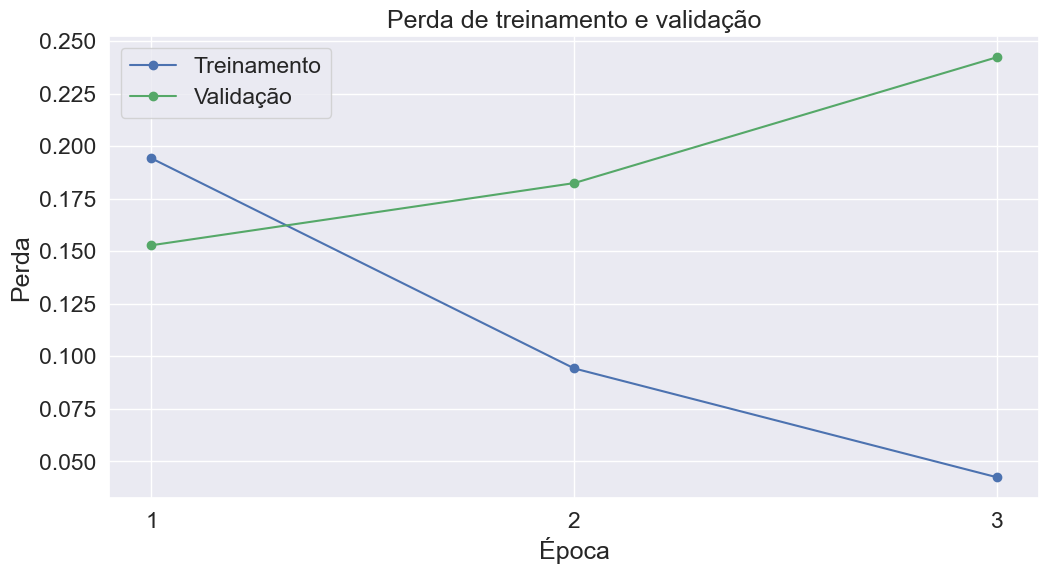

In [24]:
%matplotlib inline

# Usando o estilo do pacote seaborn
sns.set(style='darkgrid')

# Aumentando o tamanho do plot e da fonte
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plotando as curvas de perda
plt.plot(df_stats['Perda de treinamento'], 'b-o', label="Treinamento")
plt.plot(df_stats['Perda de validacao'], 'g-o', label="Validação")

# Escrevendo as legendas
plt.title("Perda de treinamento e validação")
plt.xlabel("Época")
plt.ylabel("Perda")
plt.legend()
plt.xticks([1, 2, 3])

plt.show()

# Avaliando o modelo

Depois do ajuste, vamos avaliar o desempenho do modelo no banco de teste

In [25]:
tokenizer = BertTokenizer.from_pretrained(MODEL_FOLDER)
model = BertForSequenceClassification.from_pretrained(MODEL_FOLDER, num_labels = 2, output_attentions = False, output_hidden_states = False)

model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Podemos recriar o banco de teste após o ajuste, possibilitando o treinamento e teste do modelo em seções diferentes. Caso o teste seja feita na mesma seção, não é necessário rodar o bloco abaixo.

In [26]:
# Utilizando o mapping de observação ao banco correspondente, caso seja de interesse rodar o teste em uma seção separada do treinamento
df_indexes = pd.read_csv(os.path.join(MODEL_FOLDER, 'indices_set.csv'))
test_indexes = df_indexes.loc[df_indexes['set'] == 'test', 'indice'].tolist()

Vamos executar os mesmos passos para o teste que foi feito na validação.

In [28]:
test_dataset = Subset(dataset, test_indexes)
prediction_dataloader = DataLoader(test_dataset, sampler = SequentialSampler(test_dataset), batch_size = batch_size)

model.eval()  # Coloca o modelo em modo de validação

logits, true_labels = [], []

# Para cada lote do banco de teste...
for batch in prediction_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        # Executa a função 'forward' para armazenar os valores preditos
        result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        return_dict=True)

    logits_aux = result.logits

    logits_aux = logits_aux.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Armazenando os valores reais e preditos
    logits.append(logits_aux)
    true_labels.append(label_ids)

In [30]:
# Transformando a lista de arrays para arrays
logits = np.concatenate(logits, axis=0)
true_labels = np.concatenate(true_labels, axis=0)

Vamos salvar os `np.array`'s `logits` e `true_labels` para economizar tempo de processamento

In [31]:
# Criando as pastas para armazenars os arrays de logits e true_labels
EVAL_FOLDER = os.path.join(MODEL_FOLDER, 'evaluation')

if not os.path.exists(EVAL_FOLDER): os.makedirs(EVAL_FOLDER)

# Salvando todos os arrays
np.save(os.path.join(EVAL_FOLDER, f'logits.npy'), logits)
np.save(os.path.join(EVAL_FOLDER, f'true_labels.npy'), true_labels)

In [32]:
# Importando todos os arrays
logits = np.load(os.path.join(EVAL_FOLDER, f'logits.npy'))
true_labels = np.load(os.path.join(EVAL_FOLDER, f'true_labels.npy'))

predictions = np.argmax(logits, axis=1).flatten()

## Medidas de avaliação

Lembrando que a classe está levemente desbalanceada em favor de notícias verdadeiras

In [33]:
df.loc[test_indexes].groupby('label').size()

label
0    3448
1    2766
dtype: int64

A seguir, estão descritas as definições das medidas utilizadas para avaliar os resultados do modelo ajustado. Os verdadeiros positivos (TP) representam o número de observações que foram corretamente preditas como positivas pelo modelo. Uma vez que "label" é 1 quando a notícia é falsa e 0 quando ela é verdadeira, uma predição positiva indica a classificação da notícia como falsa e, de maneira análoga, uma predição negativa indica a classificação da notícia como verdadeira. Os verdadeiros negativos (TN) representam o número de observações que foram corretamente preditas como negativas pelo modelo. Já os falsos positivos (FP) indicam o número de observações preditas incorretamente como positivas pelo modelo. Por fim, os falsos negativos (FN) indicam a quantidade de observações preditas incorretamente como negativas pelo modelo.

In [34]:
tp = sum(predictions[true_labels == 1] == 1)  # verdadeiro positivo
tn = sum(predictions[true_labels == 0] == 0)  # verdadeiro negativo
fp = sum(predictions[true_labels == 0] == 1)  # falso positivo
fn = sum(predictions[true_labels == 1] == 0)  # falso negativo

# Declarando os valores acima mas como percentuais do número de obsevações do banco de teste
tp_perc = '{0:.4%}'.format(tp/(tp + tn + fp + fn))
tn_perc = '{0:.4%}'.format(tn/(tp + tn + fp + fn))
fp_perc = '{0:.4%}'.format(fp/(tp + tn + fp + fn))
fn_perc = '{0:.4%}'.format(fn/(tp + tn + fp + fn))

Matriz de confunsão

In [37]:
pd.DataFrame({'Predito positivo': [tp, fp], 'Predito negativo': [fn, tn]}, index=['Verdadeiro positivo', 'Verdadeiro negativo'])

,Predito positivo,Predito negativo
Verdadeiro positivo,2565,201
Verdadeiro negativo,132,3316


A tabela acima, também chamada de matriz de confusão, apresenta os valores de TP, TN, FP e FN observados no banco de teste. Analisando estes dados, há um número maior de falsos negativos, 201, em comparação com os falsos positivos, 132. Isso parece sinalizar que o modelo classifica incorretamente mais as fake news como verdadeiras, do que as notícias verdadeiras como falsas. Intuitivamente, consideramos que o pior erro do modelo é o falso negativo, pois, se uma notícia provém de uma fonte idônea, não deve ser difícil perceber um erro de classificação do modelo caso ele categorize uma notícia desta fonte como falsa. Contudo, para desenvolver um processo automatizado de detecção de fake news, é de suma importância que o modelo não deixe de identificar corretamente uma notícia falsa.

Matriz de confusão considerando proporções

In [38]:
pd.DataFrame({'Predito positivo': [tp_perc, fp_perc], 'Predito negativo': [fn_perc, tn_perc]}, index=['Verdadeiro positivo', 'Verdadeiro negativo'])

,Predito positivo,Predito negativo
Verdadeiro positivo,41.2778%,3.2346%
Verdadeiro negativo,2.1242%,53.3634%


Na tabela acima, temos os mesmos dados apresentados na matriz de confusão anterior, mas em valores proporcionais, obtidos através da divisão de cada elemento da matriz de confusão pela soma de todos os seus elementos. Em porcentagem, a diferença entre os falsos positivos e negativos não parece tão grande. Além disso, considerando que aproximadamente 55,37% das notícias do banco de teste são verdadeiras e 44,63% são falsas, a tabela acima parece indicar valores aceitáveis de verdadeiros positivos e negativos.

Abaixo, serão vistos algumas medidas de avaliação da qualidade do ajuste do modelo treinado, obtidas no banco de teste. A acurácia (Hossin e Sulaiman, 2015) é a proporção entre o número de observações corretamente preditas sobre o número total de observações. Quando o conjunto de dados é desbalanceado, analisar somente a acurácia pode nos levar a conclusões errôneas. A precisão mede a proporção de previsões positivas verdadeiras entre todas as previsões positivas, ou ainda, TP/(TP + FP). Esta medida pode ser útil nos casos em que os falsos positivos prejudicam mais os resultados do que os falsos negativos. A sensibilidade corresponde à proporção de casos positivos reais corretamente previstos pelo modelo, ou seja, TP/(TP + FN). Quando os falsos negativos são mais preocupantes do que os falsos positivos esta métrica pode ser adequada. A especificidade, por sua vez, mede a proporção de predições negativas verdadeiras entre todas as observações negativas reais, ou ainda, TN/(TN + FP). Além disso, o escore F1 é definido como a média harmônica entre a precisão e a sensibilidade, sendo útil ao lidar com conjuntos de dados desbalanceados. O cálculo do escore F1 é dado por (2* precisão*sensibilidade)/(precisão + sensibilidade).

In [39]:
accuracy = (tp + tn)/(tp + tn + fp + fn)
precision = tp/(tp + fp)
sensitivity = tp/(tp + fn)
specificity = tn/(tn + fp)
f1_score = 2*(precision * sensitivity)/(precision + sensitivity)

print(f"{'Acurácia no banco de teste: ':<35}{accuracy:>.4%}")
print(f"{'Precisão no banco de teste: ':<35}{precision:>.4%}")
print(f"{'F1 no banco de teste: ':<35}{f1_score:>.4%}")
print(f"{'Sensibilidade no banco de teste: ':<35}{sensitivity:>.4%}")
print(f"{'Especificidade no banco de teste: ':<35}{specificity:>.4%}")

Acurácia no banco de teste:        94.6411%
Precisão no banco de teste:        95.1057%
F1 no banco de teste:              93.9044%
Sensibilidade no banco de teste:   92.7332%
Especificidade no banco de teste:  96.1717%


A sensibilidade foi a medida com o pior desempenho, de 92,73%. Visto que ela mede a capacidade do modelo de prever corretamente quando uma notícia é fake news, um valor baixo desta medida indica uma alta taxa de falsos negativos, considerado o pior tipo de erro para esta análise. Todavia, 92,73% pode ser interpretado como um valor alto, principalmente se considerarmos que este foi a menor das medidas observadas. A medida com o melhor desempenho foi a especificidade, com 96,17%. Esta medida possui um comportamento inverso ao da sensibilidade, sendo a taxa de notícias verdadeiras corretamente preditas. Isso significa que o modelo é particularmente bom para detectar quando uma notícia é verdadeira. Analisando o escore F1, observamos que ele também atingiu um valor elevado, de 93,90%. Considerando que o escore F1 é uma medida que penaliza a presença de dados desbalanceados, podemos inferir que o desequilíbrio presente na coluna "label" não afetou o desempenho do modelo. Por último, a acurácia e precisão no banco de teste foram de 94,64% e 95,11%, respectivamente. Por serem valores calculados no banco de teste, eles parecem indicar a ausência de overfitting do modelo. Além disso, estes pode ser considerados bons resultados, sugerindo que o modelo obteve um bom desempenho de maneira geral.

## Visualizando o ajuste

In [40]:
wrong_classification = []
for a, b, c in zip(predictions.tolist(), true_labels.tolist(), test_indexes):
    if a != b:
        wrong_classification.append(c)

Notícias que o modelo classificou de maneira incorreta.

In [41]:
df.loc[wrong_classification].sample(10)

,title,label,n_token
324,You Can't Be Intersectional While at the Same ...,1,20
29545,What Is Hillary’s Greatest Accomplishment?,0,10
7953,What Young Men Need To Know To Avoid A Statuto...,1,14
19103,James Comey Corroborates Trump Not Under Inves...,0,22
41249,Will the anti-Clinton revolt among American el...,1,14
34311,President Obama wants to disarm America,0,10
29808,A Transformational November of Taking a Stand,1,10
5276,North Korea Ready for New Missile Launch Withi...,1,11
19749,House Republicans Begin Process To Withdraw A...,1,13
22548,"Putin: No difference between Clinton, Trump",1,10


Como exemplo de um título de uma notícia verdadeira, mas que o modelo classificou como falsa, temos: "Melania Trump Is First Catholic to Live in White House Since JFK".

Já como exemplo de um título de uma notícia falsa, mas que o modelo classificou como verdadeira, temos: "In UNESCO, Palestinians claim ownership of Dead Sea Scrolls".

Os códigos utilizados para ajustar e avaliar o modelo BERT estão disponíveis para consulta no repositório https://github.com/ghsaul/tcc_project, sob a licença Creative Commons Zero v1.0 Universal.

# Conclusão

Neste trabalho, foi apresentada uma aplicação do modelo BERT para identificação de fake news em títulos de notícias de diferentes meios de comunicação americanos. Como o banco de dados possui uma variável indicando a veracidade da notícia, o problema abordado nesse trabalho envolve métodos de aprendizagem supervisionado, especificamente de classificação binária. O uso do modelo pré-treinado BERT Base Uncased e de ferramentas de programação, forneceu uma abordagem unificada para o treinamento do modelo, economizando tempo e recursos computacionais. Esta estrutura de pré-treinamento e ajuste fino que o modelo oferece, é uma das razões pelas quais o BERT se tornou uma escolha popular e eficaz na área de Processamento de Linguagem Natural (Zhao et al., 2022).

Baseando-se em métricas como acurácia, precisão e sensibilidade, concluímos que o modelo ajustado obteve um bom desempenho na tarefa de classificar notícias falsas em inglês. Isto parece evidenciar que modelos capazes de representar o significado de uma palavra a partir do seu contexto podem alcançar um bom desempenho em tarefas de NLP. Os resultados deste trabalho podem contribuir no combate à desinformação e auxiliar aplicações na área como Giordani et al. (2022). Apesar do bom desempenho, o método pode ser aperfeiçoado ainda mais. Caso fosse utilizado o texto completo da notícia em vez de apenas o seu título, o modelo possivelmente ganharia um contexto mais abrangente. No entanto, isto não foi feito devido à limitações de recursos computacionais.

Em trabalhos futuros, é possível utilizar alguma modificação do modelo GPT (Radford et al., 2018) para produzir avanços no estudo de detecção de fake news. Além disso, é interessante aplicar o método de gradientes integrados (Sundararajan et al., 2017), implementado no pacote em Python captum (Kokhlikyan et al., 2020). Esta técnica permite visualizar a importância de cada token à predição do modelo, contribuindo com a interpretabilidade do BERT. Por fim, é possível usar variações do BERT que utilizam texto e imagem simultaneamente como dado de entrada do modelo, para analisar fake news não somente em textos, mas também em imagens alteradas digitalmente. Dentre os modelos disponíveis deste tipo, temos o Visual-Linguistic BERT (VL-BERT) (Su et al., 2019), o UNiversal Image-TExt Representation (UNITER) (Chen et al., 2020) e o VisualBERT (Li et al., 2019).